# Un Ejercicio con Census

El ritmo de trabajo que ha de seguirse para ML Supervisado:

        1) Se limpian y preparan los datos brevemente en el EDA
        2) Se separan los datos en:
            - Valores categóricos
            - Valores numéricos
                * Se exploran ambos para ver qué contienen y así poder realizar predicciones a ojo
        3) Se preparan las pipelines según la separación
        4) Se juntan las pipelines y se entrena el modelo
        5) Se realiza una validación de cruce (cross-validation) del modelo para ver si se puede mejorar
        6) Se ajusta el modelo
        7) Se exporta a pickle (formato .sav) para futuros usos

In [1]:
# Librerías de análisis
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import io
import requests

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

# Liberías de Visualización
 seaborn as sns
importfrom matplotlib import pyplot as plt
%matplotlib inline
import pickle

print('ready')

ready


In [2]:
# Clases para el ML

# Para valores NUMERICOS
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])


# Para valores CATEGORICOS
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)


class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy is 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

In [3]:
# Creando los dfs que usaremos para entrenar y testear, train y test respectivamente

columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\general_dfs\adult.data', names = columns, sep=' *, *', na_values='?',engine='python')
test_data = pd.read_csv(r'F:\Programacion\1.BOOTCAMP\data\general_dfs\adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?',engine='python')

Explorando los dfs. Hay que ver si hay valores NaN

In [4]:
train_data.head(1)

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [5]:
test_data.head(1)

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.


In [6]:
print(f'Train\n{train_data.isnull().sum()}\n\nTest\n{test_data.isnull().sum()}')

Train
age                  0
workClass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Test
age                 0
workClass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


Hay NaNs. Así que toca o eliminarlos o rellenarlos de alguna manera

# Creando las pipelines 1 Selección de datos

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
num_attributes = train_data.select_dtypes(exclude=['object', 'bool'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [9]:
cat_attributes = train_data.select_dtypes(exclude=['int64'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


# Creando las Pipelines 2.1 Numerical data

Primero hay que representar los datos que tienes, para poder entenderlos mejor.

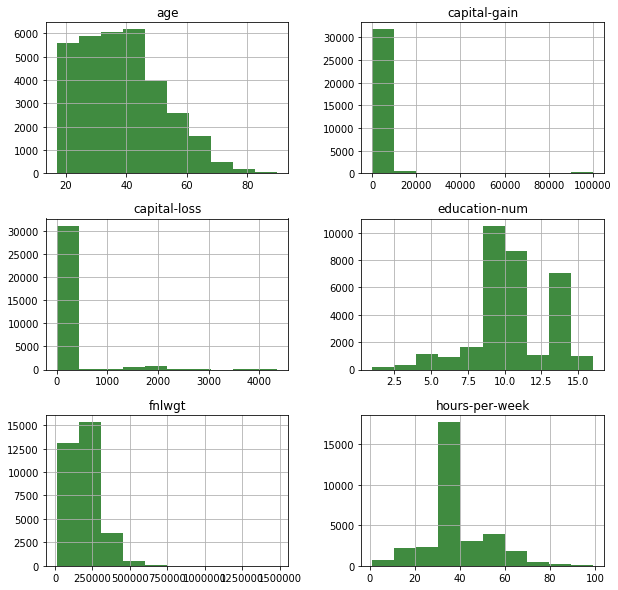

In [10]:
num_attributes.hist(figsize=(10,10), color = 'darkgreen', alpha = 0.75);

In [11]:
num_attributes.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Ya sabiendo cómo son los datos de los que disponemos, se pueden empezar a realizar operaciones. IMPORTANTE
    1) Determinar si hay NaNs
    2) Si los datos están en la misma escala (y de no ser así, utilizar el Standard_Scaler para que así sea)

In [12]:
# Creación de la Pipeline para númerico
num_pipeline = Pipeline(steps=[("num_attr_selector", ColumnsSelector(type='int64')), ("scaler", StandardScaler())])

Importante destacar cómo funciona esto: Pasa por la clase ColumnSelector y utiliza el StandarScaler para librarse de los NaNs. Este último tiene varios métodos de relleno desde la media (mean) al más dato más frecuente.

In [13]:
num_pipeline.fit_transform(train_data)

array([[ 0.03067056, -1.06361075,  1.13473876,  0.1484529 , -0.21665953,
        -0.03542945],
       [ 0.83710898, -1.008707  ,  1.13473876, -0.14592048, -0.21665953,
        -2.22215312],
       [-0.04264203,  0.2450785 , -0.42005962, -0.14592048, -0.21665953,
        -0.03542945],
       ...,
       [ 1.42360965, -0.35877741, -0.42005962, -0.14592048, -0.21665953,
        -0.03542945],
       [-1.21564337,  0.11095988, -0.42005962, -0.14592048, -0.21665953,
        -1.65522476],
       [ 0.98373415,  0.92989258, -0.42005962,  1.88842434, -0.21665953,
        -0.03542945]])

# Creando las Pipelines 2.2 Categorical Data

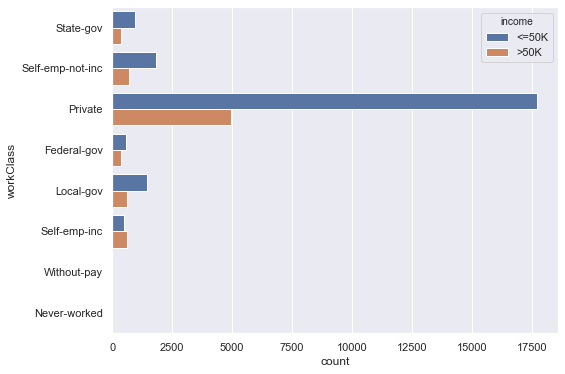

In [14]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(y='workClass', hue='income', data = cat_attributes);

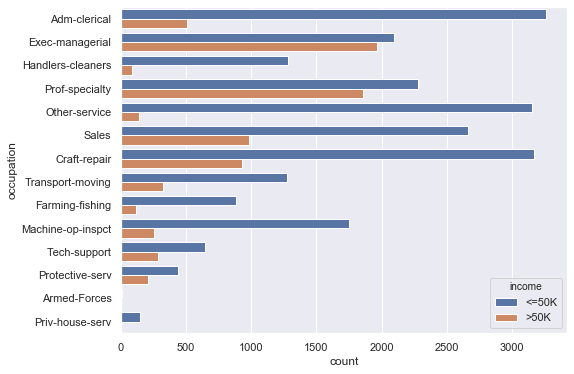

In [15]:
sns.countplot(y='occupation', hue='income', data=cat_attributes);

Hay NaNs en determinadas columas. Estas se reemplazarán con la ocurrencia más frecuente (most_frequent) dentro de las cols afectadas. 

In [16]:
cat_pipeline = Pipeline(steps=[("cat_attr_selector", ColumnsSelector(type='object')), ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])), ("encoder", CategoricalEncoder(dropFirst=True))])

In [17]:
cat_pipeline.fit_transform(train_data).shape

(32561, 94)

# Unión de las Pipelines

In [18]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

Con esto ¿Qué hemos conseguido?

    - Primero, al dividir el df por categorías, hemos podido operar y entender estas acategorías mucho más rápidamente que si lo hubiésemos hecho a mano.
    - Segundo, la creación de Pipelines de trabajo nos ha permitido trabajar con los datos de forma específica, pero automática. Más rápidamente de lo que hubiera sido posible a mano.
    - Tercero, hemos realizado una simulación de entrenamiento de los diferentes modelos de ML supervisados (categóricos y numéricos) por separado, antes de unirlos en una nueva tupla y entrenarlos de forma conjunta.



# Entrenamiento del modelo

In [19]:
# Eliminación de columnas inútiles en el modelo
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [20]:
# Copia por si las moscas
train_copy = train_data.copy()

# Converisión de la columna income a valores 0-1 y eliminación para la creación de vectores
train_copy["income"] = train_copy["income"].apply(lambda x:0 if x=='<=50K' else 1)


X_train = train_copy.drop('income', axis =1)

# Valores objetivo. Aquí es donde está income
Y_train = train_copy['income']

print(X_train.columns)
print(X_train.shape)

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')
(32561, 12)


Eliminamos income, porque luego nos va a servir de referencia en target.

In [21]:
X_train_processed = full_pipeline.fit_transform(X_train)
print(X_train_processed.shape)

(32561, 81)


In [22]:
# Entrenamiento del bot
model = LogisticRegression(random_state=0,solver='liblinear')

model.fit(X_train_processed, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
model.coef_

array([[ 0.31306553,  0.77338452,  2.30509242,  0.26045209,  0.39253973,
        -0.40787014, -0.05813807, -0.17593699,  0.22195355,  0.56450752,
        -0.98413498, -0.22955707, -2.11605066, -1.62759539, -1.71742943,
        -1.51818422, -1.64022404,  0.33913943, -0.1729858 ,  0.49431953,
        -0.26312801,  0.01120579, -1.06710483, -0.50085073, -0.34257912,
        -0.89345581, -1.29267772,  0.35680664,  0.24145634, -1.81464569,
        -0.46150648,  0.01057189, -1.17822906, -0.13030831,  1.28165965,
        -0.70875291, -0.17213063, -0.06187148, -0.58553936, -0.45028277,
        -0.83418469, -0.57315992,  0.38622092,  0.26337837, -0.42409231,
         0.11009781, -0.60070239, -0.30308446,  0.24589115,  0.13462504,
        -0.59096354, -0.99019765, -0.09318999,  0.62668429, -1.18550286,
         0.26021302, -0.20893523, -0.11060504, -0.94038595, -1.42511795,
        -0.14765811, -0.16200831,  0.04955464, -0.08886276, -0.8576275 ,
        -0.61746112, -0.53200114, -0.26237324,  0.3

# Testeando el modelo

In [24]:
# Una copia de test, por si las moscas
test_copy = test_data.copy()

# Columna income sufre el mismo destino que antes
test_copy["income"] = test_copy["income"].apply(lambda x:0 if x=='<=50K.' else 1)
X_test = test_copy.drop('income', axis =1)

# Testeando
Y_test = test_copy['income']

X_test.columns

Index(['age', 'workClass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')

In [25]:
# Preprocesamiento de datos utilizando el full_pipeline

X_test_processed = full_pipeline.fit_transform(X_test)
X_test_processed.shape

(16281, 81)

In [26]:
predicted_classes = model.predict(X_test_processed)
print(predicted_classes)

[0 0 0 ... 1 0 1]


# Evaluación de modelo

In [27]:
# Utilizando accuracy_score obtenemos una precisión de...

model_accuracy = round(accuracy_score(predicted_classes, Y_test.values), 4) *100
print(f'{model_accuracy}%')

85.25%


[[11583  1550]
 [  852  2296]]


Text(48.5, 0.5, 'Actual classes')

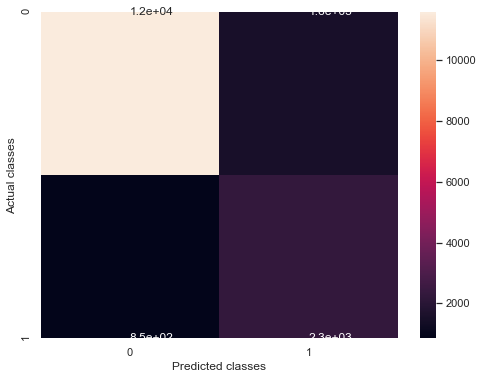

In [28]:
# Matriz de confusión
sns.set(rc={'figure.figsize':(8,6)})
cfm = confusion_matrix(predicted_classes, Y_test.values)
akws = {"ha": 'left',"va": 'center'}
sns.heatmap(cfm, annot=cfm, annot_kws=akws)
print(cfm)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [29]:
cfm

array([[11583,  1550],
       [  852,  2296]], dtype=int64)

Por coordenadas:
- 0,0 Representa el número de Clase 0 que el modelo ha acertado
- 0,1 Son el núero de Clase 1 que hemos predicho como 0
- 1,0 Es el número de Clase 0 que hemos predicho como 1
- 1,1 Representa el número de Clase 1 que el modelo ha acertado

# Cross Validación

Utilizando StratifiedKFold (mucho mejor que KFold, porque no permite que se introduzcan sesgos en el modelo con la misma facilidad) vamos a realizar el cruce de validación. Después se usará cross_val_score para computar los valores correspondientes. cv determina el patrón de la validación de cruce.

In [48]:
# Modelo de validación de cruce, es una regresión logística random
cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_train_processed, Y_train, cv=5)

print(scores)
print(np.mean(scores))

[0.84722862 0.84920147 0.85257985 0.85350123 0.8519656 ]
0.8508953553863734


# Ajustes al modelo

Utilizando GridSearchCV podemos ajustar el modelo

In [30]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
random_state=[0]

# Creación de diccionario de hiperparámetros
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

In [31]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, cv=5, verbose = 4)
best_model = clf.fit(X_train_processed, Y_train)                    # Mejora de modelo


print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=1.0, penalty=l1, random_state=0 ...............................
[CV] ... C=1.0, penalty=l1, random_state=0, score=0.847, total=   0.2s[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

[CV] C=1.0, penalty=l1, random_state=0 ...............................
[CV] ... C=1.0, penalty=l1, random_state=0, score=0.849, total=   0.2s
[CV] C=1.0, penalty=l1, random_state=0 ...............................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] ... C=1.0, penalty=l1, random_state=0, score=0.852, total=   0.2s
[CV] C=1.0, penalty=l1, random_state=0 ...............................
[CV] ... C=1.0, penalty=l1, random_state=0, score=0.854, total=   0.1s
[CV] C=1.0, penalty=l1, random_state=0 ...............................
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

In [32]:
# Prediciendo valores con el nuevo modelo
best_predicted_values = best_model.predict(X_test_processed)

print(best_predicted_values)

[0 0 0 ... 1 0 1]


In [44]:
model_accuracy_2 = round(accuracy_score(best_predicted_values, Y_test.values), 4) *100

print(f'Best model accuracy: {model_accuracy}%')
print(f'1st model accuracy: {model_accuracy}%')
print ('Difference: ',(model_accuracy - model_accuracy_2)*100, '%')

Best model accuracy: 85.25%
1st model accuracy: 85.25%
Difference:  2.000000000001023 %


Text(48.5, 0.5, 'Actual classes')

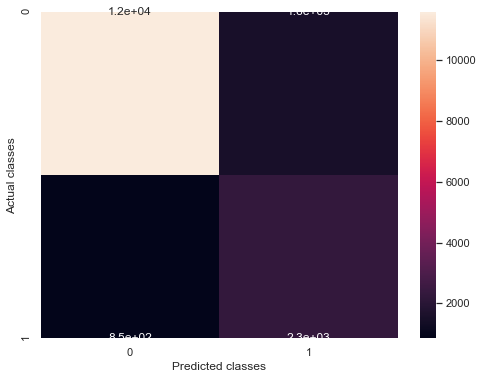

In [47]:
sns.set(rc={'figure.figsize':(8,6)})
cfm = confusion_matrix(best_predicted_values, Y_test.values)
sns.heatmap(cfm, annot=True)

plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [46]:
cfm

array([[11582,  1551],
       [  853,  2295]], dtype=int64)

# Salvando el modelo a Pickle

In [49]:
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [50]:
saved_model = pickle.load(open(filename, 'rb')) 

print(saved_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Modelo está listo para su uso en futuras predicciones. Et voilá!